In [1]:
%matplotlib inline
from pylab import *
%load_ext autoreload
%autoreload 2

# Path to Custom Modules:

In [15]:
import os
import sys

In [18]:
path_to_folder = os.getcwd()
path_to_custom_modules = path_to_folder + '\\MODULES'
sys.path.append(path_to_custom_modules)

In [17]:
#Import:
from stokes.stokestomography import *
from custom_plotting import complexToRGB
from fibremodes.transmission_matrix_generator import *
from fibremodes import ModesGen as mg
from fibremodes.ModesGen import overlaps
from stokes.processingTools import phase_retrival


# Generate the bases - LG bases

## Input parameters:

In [94]:
#Bases we are gonna use: LG modes
downsample = 1 # In case we want to dowsample
w0 = 17/downsample
mfd = w0*2 #mode field diameter
ng = 5 # Number of Mode Groups
px = 128//downsample
Apx = 1 #step

In [95]:
#Set CPU instead GPU if cupy is not supported, set multicore to False if numba is not supported
LGbases = mg.LGmodes(mfd,ng,px,Apx, generateModes = True, wholeSet= True, engine='GPU', multicore=True) 
mm_gra = LGbases.LGmodesArray__
mm_gra.shape
modesCount = mm_gra.shape[0]

LG2D = reshape(mm_gra,(mm_gra.shape[0],-1)) #2D LG to use for overlaps
LG2D = transpose((LG2D))

Generating modes coeficients...
Generating modes...
Engine : GPU
Mem. avaliable  10.4970703125  mem. needed  0.00439453125  in Gb
Generating rest of the modes...


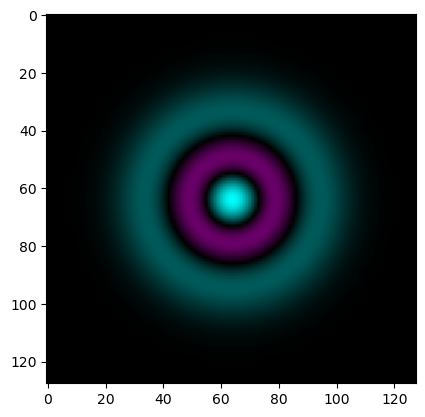

In [96]:
#Check dimension of the last mode as sanity check
figure()
imshow(complexToRGB(mm_gra[-1,...]))

# Create a random GI-MMF MTM based on the LG bases already generated

1.0

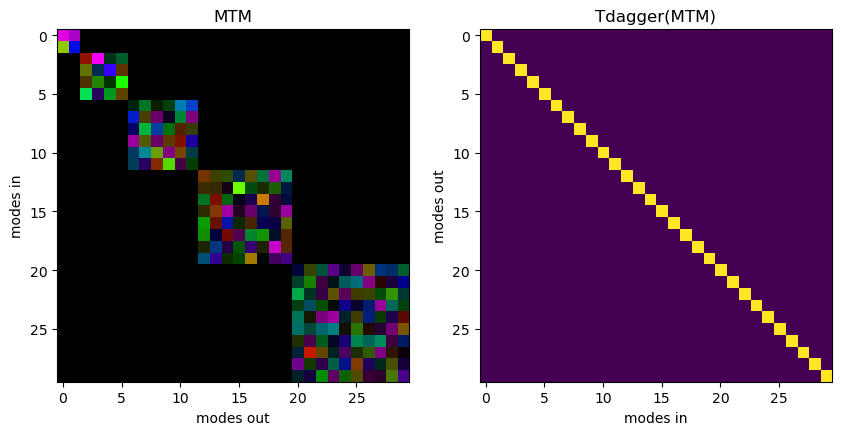

In [806]:
#Transmission Matrix we will be using - Randomly generated with 2 polarization states
pols = ['H', 'V']
#Here the phase offset between pols is completly random so there is not chance to figure the right phase between them.
#In the real experiment with a polarization diversity system H and V travel same distance from input to camera plane then phase between both sides of the camera can be stablish
polscount = len(pols)
MTM = make_MMF_GI_MTM(ng ,pols = polscount) # order is HVHVHVHV (input) - HVHVHVHV (output)
f, ax = subplots(1,2, figsize=(10,10))
ax[0].imshow(complexToRGB(MTM))
ax[0].set_title('MTM')
ax[0].set_ylabel('modes in')
ax[0].set_xlabel('modes out')
#Check all good
U = abs(matmul(MTM,transpose(conj(MTM)))**2)
ax[1].imshow(abs(U)**2)
ax[1].set_title('Tdagger(MTM)')
ax[1].set_xlabel('modes in')
ax[1].set_ylabel('modes out')

sum(abs(U)**2)/MTM.shape[0]

# SST set up:

In [690]:
GellmanMatrices, stokeStates, stokesWeights = StokesTomography(modesCount * polscount)
#GellmanMatrices, stokeStates, stokesWeights = StokesTomography_sparse(modesCount * polscount) # Set up need to be computed using sparse algebra if the number of modes if too large such a way there is not enought ram


Num. of Matrices 899
StokesStates: (1770, 30)
StokesWeight: (899, 1770)
Extracting eigenvalues and eigenVectors ...
Done
Getting the unique eigenvectors ...
Stokes Projections found =  1770  -- SUCCESS


## Generate the input analyzer states, using the SST setup and the LG bases:

In [691]:
# odd coef are H even V --> I could also split them as HHHHHHH VVVVVV instead of HVHVHVHV
HstokeStates = stokeStates[:,::2]
VstokeStates = stokeStates[:,1::2]
print(stokeStates.shape)

(1770, 30)


In [692]:
#Generate the ANALyZER states at the input of the fibre. They are not need for the simulation, only the coeficients are need it
analyzerStateIN_H = overlaps.Modal_reconstruction(LG2D,HstokeStates)
analyzerStateIN_V = overlaps.Modal_reconstruction(LG2D,VstokeStates)

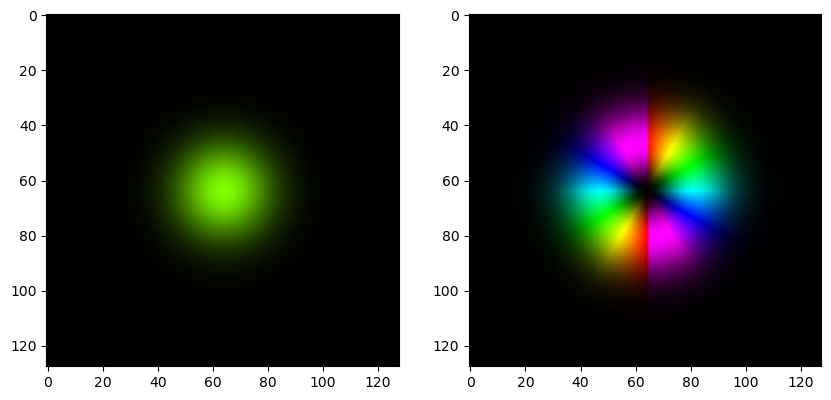

In [693]:
fig, ax = subplots(1,2, figsize = (10,5))

projection_idx = 176
ax[0].imshow(complexToRGB(analyzerStateIN_H[projection_idx,...]))    
ax[1].imshow(complexToRGB(analyzerStateIN_V[projection_idx,...]))    
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set_title('Input field H')
ax[1].set_title('Input field V')


# Propagate the input analyzer state through the 'unknown' MTM:

In [694]:
#At the output of the fibre we will be projecting the following:
stokeStates = stokeStates
analyzerStateOut_coef = matmul(stokeStates, (MTM)) #coefficients

In [695]:
# Fields reconstruction
analyzerStateOut_H = overlaps.Modal_reconstruction((LG2D),analyzerStateOut_coef[:,::2])
analyzerStateOut_V = overlaps.Modal_reconstruction((LG2D),analyzerStateOut_coef[:,1::2])

In [696]:
#Detected power - Equivalent to what we will measure in the experiment
analyzerStateOutPOW_H = abs(analyzerStateOut_H)**2
analyzerStateOutPOW_V = abs(analyzerStateOut_V)**2

Text(0.5, 1.0, 'frame(V)')

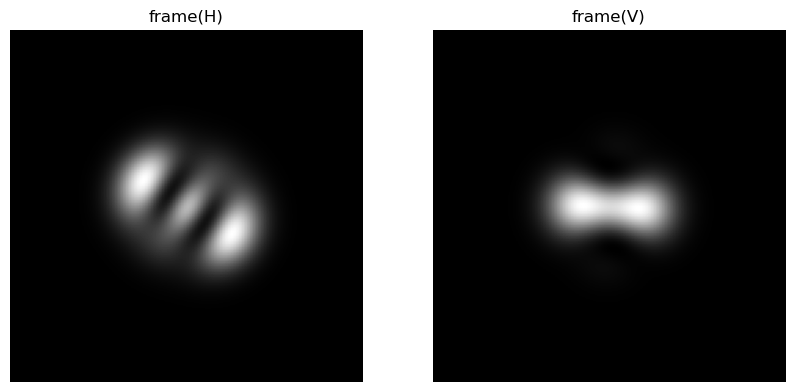

In [812]:
fig, ax = subplots(1,2, figsize = (10,5))

projection_idx = projection_idx
#Camera frames - H and V
ax[0].imshow((analyzerStateOutPOW_H[projection_idx,...]),cmap ='gray')    
ax[1].imshow((analyzerStateOutPOW_V[projection_idx,...]), cmap = 'gray')   
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set_title('frame(H)')
ax[1].set_title('frame(V)')


# Processing of the intensity measurements:

In [697]:
analyzerStatesOutPOW = {'H': analyzerStateOutPOW_H, 'V':analyzerStateOutPOW_V} #Pack the measured data
#create some containers:
Sn = {'H': None, 'V': None}
densityMatrix = {'H': None, 'V': None}
eigenValues = {'H': None, 'V': None}
eigenVectors = {'H': None, 'V': None}
S0 = {'H': None, 'V': None}
MTMs = {'H': None, 'V': None}

#Processing
for polidx in pols:
    print(f'Processing: {polidx}')
    #Set GPU to false if cupy is not supported, set ForcePSD is there is not need to force density matrices to be positive semi definite. StokesVectorCalc hanfles sparse or non-sparse matrices automatically
    Sn[polidx], densityMatrix[polidx], eigenValues[polidx], eigenVectors[polidx], S0[polidx] = StokesVectorCalc(GellmanMatrices, stokesWeights, (analyzerStatesOutPOW[polidx] + 1e-23 ), ForcePSD = False, GPU = True)
    MTMs[polidx] = eigenVectors[polidx][:,:,0] * sqrt(S0[polidx][:,None]) #Matrix mapping LG bases to spot bases
print(MTMs['H'].shape)

Processing: H
Casting arrays to csr matrix before calculation...
StokesVector... 
Done
DenstyMatrix... 
Done
Calculating eigenValues and eigenVectors...
GPU on
Memory needed: 0.3369140625 Gb, GPU mememory avaliable: 10.4970703125
Done
Processing: V
Casting arrays to csr matrix before calculation...
StokesVector... 
Done
DenstyMatrix... 
Done
Calculating eigenValues and eigenVectors...
GPU on
Memory needed: 0.3369140625 Gb, GPU mememory avaliable: 10.4970703125
Done
(16384, 30)


## Check Singular Values of the LG to pixel bases(MTMs)

MDL -1.0354388280120475e-06
IL 3.814697265625e-06


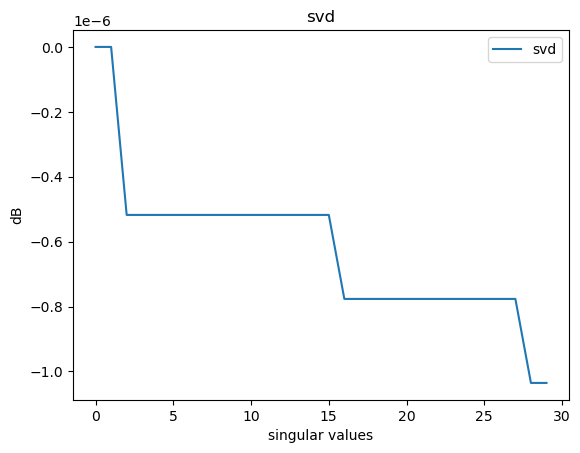

In [813]:

MTMs_interlev = vstack((MTMs['H'],MTMs['V']))
u, s, vh = linalg.svd(MTMs_interlev, full_matrices=False)
plot(10*log10(s/s.max()),label = 'svd')
title('svd')
ylabel('dB')
xlabel('singular values')
#xlim([0,14])
legend()

s_norm = s /s.max()
#In absense of noise MLD and IL should be near 0
print('MDL', 10*log10(s_norm[-1])) #Obviously only numbercount are supported
print('IL', s.shape[0] - (sum(s/s.max())))

# Find the phase between the bases at the output (camera side - pixels)

In [699]:
outSpots_coefs = {'H': None, 'V': None}
Aphi = {'H': None, 'V': None}

for polidx in pols:
    print(f'Correcting: {polidx}')
    outSpots_coefs[polidx], Aphi[polidx], w = phase_retrival.lockPhase(MTMs[polidx], jit = True)

Correcting: H
Correcting: V


# Spot bases to LG bases transformation - In this case we use same bases as the input

In [700]:
#Generate the ideal target - array of spots/pixels
spot_array = eye(px**2,px**2)
spot_array = reshape(spot_array,(px**2,px,px))
spot_array_coefs = overlaps.Modal_decomposition((LG2D),spot_array).astype(complex64)

In [701]:
spot_array_coefs.dtype

dtype('complex64')

In [799]:
def doOverlap2(a,b):
    a = a / sqrt(sum(abs(a)**2))
    b = b / sqrt(sum(abs(b)**2))
    
    ov = average(a*conj(b))
    return ov 

MTM_retrived_pol = {'H': None,'V': None}

Aphi_MTM = angle(doOverlap2(MTM[:,::2], MTM[:,1::2]))
print('Target phase ', Aphi_MTM)

#Transformation
for polidx in pols:
    MTM_retrived_pol[polidx] = matmul(transpose(outSpots_coefs[polidx][:,:]), spot_array_coefs[:,:])

#Lock the phase between pols
MTM_retrived = zeros((MTM_retrived_pol['H'].shape[0], MTM_retrived_pol['H'].shape[0]),complex64)
MTM_retrived[:,::2] = MTM_retrived_pol['H']
LockPols = angle(doOverlap2(MTM_retrived_pol['H'], MTM_retrived_pol['V']))

#MTM(H) and MTM(V) was created randomly so it does not really mattern in here. With real data need to be taken into account since H and V side of the camera travel same path
#then, they should have same overal phase offset
MTM_retrived[:,1::2] = MTM_retrived_pol['V'] * exp(-1j * LockPols) # I

print('Final matrix shape', MTM_retrived.shape)
print('MTM dimension', MTM_retrived.shape)
print('Measured spots --> LG :',outSpots_coefs['H'].shape)
print('Phase offset between pols:', LockPols) # This does not have physical meaning in the simulation since MTM(H) and MTM(V) phase relationship is random

Target phase  -2.2142975
Final matrix shape (30, 30)
MTM dimension (30, 30)
Measured spots --> LG : (16384, 30)
Phase offset between pols: -2.6779451


Overlas respect the theoretical MTM:
H --> 0.9999999491373757
V --> 1.000000016954231


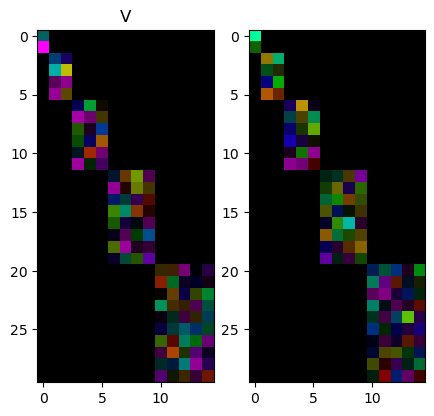

In [762]:
f, ax = subplots(1,2,figsize=(5,5))

ax[0].imshow(complexToRGB(MTM_retrived[:,0::2]))
ax[1].imshow(complexToRGB(MTM_retrived[:,1::2]))
ax[0].set_title('H')
ax[0].set_title('V')

MTM_H_retrived = sum(abs(MTM_retrived[:,0::2])**2)
MTM_V_retrived = sum(abs(MTM_retrived[:,1::2])**2)

print('Overlas respect the theoretical MTM:')
print('H -->', abs(sum(MTM_retrived[:,::2] * ((MTM[:,::2]))))**2 / (sum(abs(MTM_retrived[:,::2])**2) * sum(abs(MTM[:,::2])**2)) )
print('V -->', abs(sum(MTM_retrived[:,1::2] * ((MTM[:,1::2]))))**2 / (sum(abs(MTM_retrived[:,1::2])**2) * sum(abs(MTM[:,1::2])**2)) )

# Combine matrices:

Overlap 0.32498316918197534


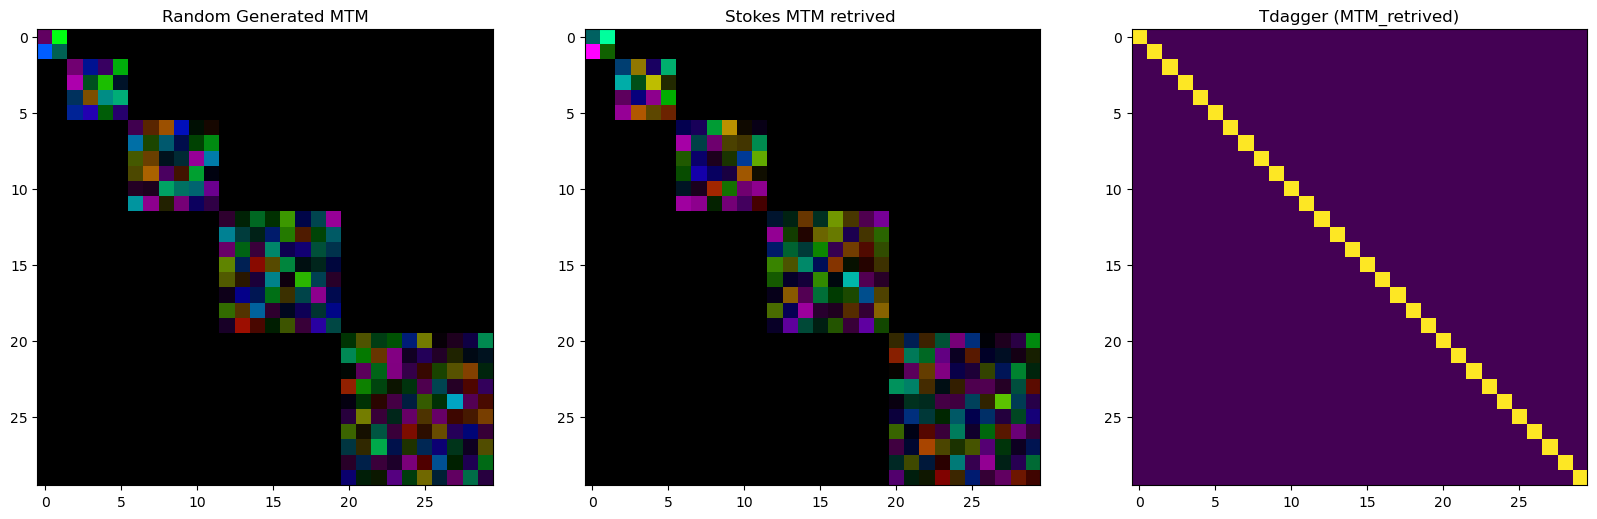

In [763]:
f, ax = subplots(1,3,figsize=(20,20))

ax[0].imshow(complexToRGB(MTM))
ax[0].set_title('Random Generated MTM')
ax[1].imshow(complexToRGB(MTM_retrived))
ax[1].set_title('Stokes MTM retrived ')

#Check all good
U = abs(matmul(MTM_retrived,transpose(conj(MTM_retrived)))**2)
ax[2].imshow(abs(U)**2)
ax[2].set_title('Tdagger (MTM_retrived)')

MDL -2.5885975674100337e-06
IL 3.814697265625e-06


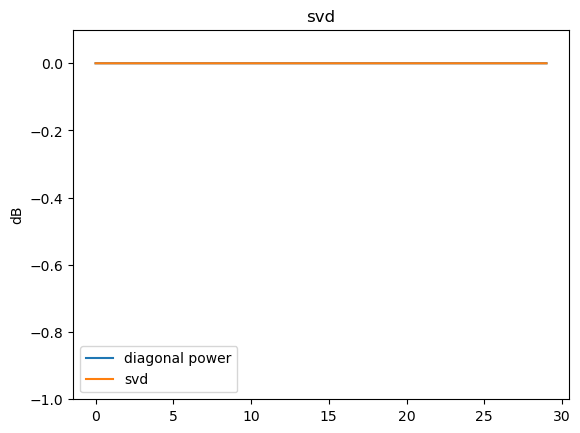

In [731]:
u, s, vh = linalg.svd(MTM_retrived, full_matrices=True)
plot(10*log10(U.diagonal() / (U.diagonal()).max()), label = 'diagonal power')
plot(10*log10(s/s.max()),label = 'svd')
title('svd')
ylabel('dB')
ylim([-1,0.1])
legend()

s_norm = s /s.max()
print('MDL', 10*log10(s_norm.min()))
print('IL',  s.shape[0] - (sum(s/s.max())))